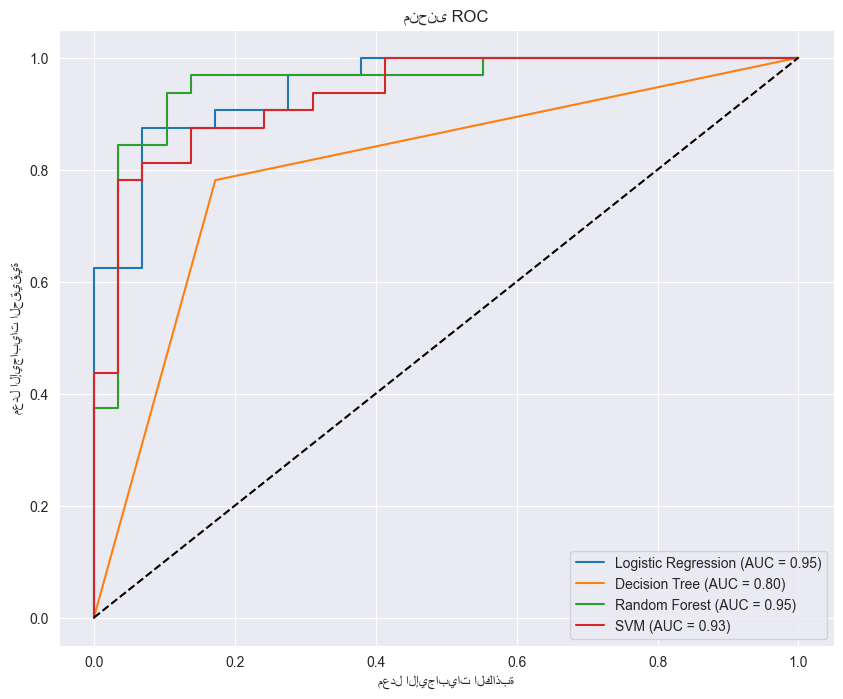

                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.868852   0.868852  0.868852  0.868852
1        Decision Tree  0.803279   0.805218  0.803279  0.803384
2        Random Forest  0.885246   0.889539  0.885246  0.885246
3                  SVM  0.852459   0.856593  0.852459  0.852459


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import os

# التأكد من وجود المجلدات
os.makedirs('../results/evaluation', exist_ok=True)
os.makedirs('../data', exist_ok=True)

# تحميل البيانات
data = pd.read_csv('../data/selected_features.csv')  # السمات المختارة
X = data

# تحميل عمود target من البيانات الأصلية
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data_original = pd.read_csv(url, names=columns)
data_original = data_original.replace('?', np.nan)
data_original['ca'] = data_original['ca'].astype(float)
data_original['thal'] = data_original['thal'].astype(float)
data_original = data_original.fillna(data_original.mean())

# تحويل الهدف إلى تصنيف ثنائي (0 = لا مرض، >0 = مرض)
y = (data_original['target'] > 0).astype(int)

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# إنشاء النماذج
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# تقييم النماذج
results = []
plt.figure(figsize=(10, 8))
for name, model in models.items():
    # تدريب النموذج
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    # حساب المقاييس
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

    # رسم منحنى ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# إعدادات منحنى ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('معدل الإيجابيات الكاذبة')
plt.ylabel('معدل الإيجابيات الحقيقية')
plt.title('منحنى ROC')
plt.legend()
plt.savefig('../results/evaluation/roc_curve.png')
plt.show()

# حفظ النتائج
results_df = pd.DataFrame(results)
results_df.to_csv('../results/evaluation/evaluation_metrics.csv', index=False)

# عرض النتائج
print(results_df)